In [1]:
%matplotlib inline
import gym
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from collections import deque
from IPython import display
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from scipy import stats
from training_methods import *
%load_ext autoreload
%autoreload

run_name = 0

## Action is added to input as OHE

In [17]:
class ActionAsInputAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()
        
    def _build_model(self):
        input_len = self.params.state_size + self.params.action_size

        self.x = tf.placeholder("float", [None, input_len], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, 1], name="Placeholder_y")

        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=1,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state, frame))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        X = np.resize(state, (1, self.params.state_size + self.params.action_size))
        X[0, self.params.state_size:] = 0
        
        rewards = np.zeros((self.params.action_size))
        for i in range(self.params.action_size):
            X[0, self.params.state_size + i] = 1
            rewards[i] = session.run(self.pred, {self.x: X})[0]
            X[0, self.params.state_size + i] = 0
        return np.argmax(rewards)
    
    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size + self.params.action_size))
        Y = np.zeros((cnt, 1))
        for i in range(cnt):
            state, action, reward, next_state, frame = self.memory[i]
            inp = np.resize(state, (self.params.state_size + self.params.action_size))
            inp[self.params.state_size:] = 0
            inp[self.params.state_size + action] = 1
            X[i], Y[i] = inp, reward

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = X[batch_indexes]
            batch_y = Y[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

## Policy Gradient

Run with `params.episodes_between_think = 1`

Karpathy: https://gist.github.com/karpathy/a4166c7fe253700972fcbc77e4ea32c5

TF interpretation: https://gist.github.com/greydanus/5036f784eec2036252e1990da21eda18

In [2]:
class PolicyGradientAgent:
    def __init__(self, params):
        self.params = params
        self.memory = deque(maxlen=self.params.max_memory_size)
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name='Placeholder_x')
        self.y = tf.placeholder("float", [None, self.params.action_size], name='Placeholder_y')

        h0 = tf.contrib.layers.fully_connected(
            inputs=self.x,
            num_outputs=20,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=h0,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)

        optimizer = tf.train.RMSPropOptimizer(self.params.learning_rate_model, decay=0.99)
    
        gradients = optimizer.compute_gradients(self.cost, var_list=tf.trainable_variables())
        self.train_op = optimizer.apply_gradients(gradients)

    def remember(self, state, action, reward, next_state, frame):
        self.memory.append((state, action, reward, next_state))

    def act(self, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(state, frame)
    
    def act_greedy(self, state, frame):
        act_values = session.run(self.pred, feed_dict={self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, batch_size, episode):
        cnt = len(self.memory)
        X = np.zeros((cnt, self.params.state_size))
        Y = np.zeros((cnt, self.params.action_size))
        for i in range(cnt):
            state, action, reward, next_state = self.memory[i]
            target = session.run(self.pred, feed_dict={self.x: [state]})[0]
            target[action] = reward
            X[i], Y[i] = state, target

        _ = session.run(self.train_op, {self.x: X, self.y: Y})

## DQN Agent

In [73]:
class DqnAgent:
    def __init__(self, params):
        self.params = params
        self.memory_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_next_states = np.zeros((2 * self.params.max_memory_size, self.params.state_size))
        self.memory_actions = np.zeros((2 * self.params.max_memory_size), dtype=np.int32)
        self.memory_rewards = np.zeros((2 * self.params.max_memory_size, 1))
        self.cnt = 0
        self._build_model()

    def _build_model(self):
        self.x = tf.placeholder("float", [None, self.params.state_size], name="Placeholder_x")
        self.y = tf.placeholder("float", [None, self.params.action_size], name="Placeholder_y")

#         x = tf.reshape(self.x, (tf.shape(self.x)[0], 19, 16, 4))
#         conv1 = tf.contrib.layers.conv2d(x, 16, 4, 2, activation_fn=tf.nn.relu)
#         flattened = tf.contrib.layers.flatten(conv1)

        flattened = self.x

        fc1 = tf.contrib.layers.fully_connected(flattened, 32,
            activation_fn=tf.nn.relu,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.pred = tf.contrib.layers.fully_connected(
            inputs=fc1,
            num_outputs=self.params.action_size,
            activation_fn=None,
            weights_initializer=tf.contrib.layers.xavier_initializer())
        
        self.cost = tf.nn.l2_loss(self.pred - self.y)
        self.train_op = tf.train.RMSPropOptimizer(learning_rate=self.params.learning_rate, decay=0.99) \
            .minimize(self.cost)
#         train_op = tf.train.AdamOptimizer(learning_rate=self.params.learning_rate_model).minimize(cost)

    def remember(self, state, action, reward, next_state, frame):
        self.memory_states[self.cnt] = state
        self.memory_next_states[self.cnt] = next_state
        self.memory_actions[self.cnt] = action
        self.memory_rewards[self.cnt] = reward
        self.cnt += 1
        
        if self.cnt == 2 * self.params.max_memory_size:
            n = self.params.max_memory_size
            self.memory_states[:n] = self.memory_states[-n:]
            self.memory_next_states[:n] = self.memory_next_states[-n:]
            self.memory_actions[:n] = self.memory_actions[-n:]
            self.memory_rewards[:n] = self.memory_rewards[-n:]
            self.cnt = n

    def act(self, session, state, frame):
        if np.random.rand() <= self.params.epsilon:
            return np.random.randint(0, self.params.action_size)
        return self.act_greedy(session, state, frame)
    
    def act_greedy(self, session, state, frame):
        act_values = session.run(self.pred, {self.x: [state]})[0]
        return np.argmax(act_values)

    def think(self, session, batch_size, episode):
        cnt = self.cnt
        
        values = session.run(self.pred, {self.x: self.memory_states[:cnt]})
        nextValues = session.run(self.pred, {self.x: self.memory_next_states[:cnt]})
        
        values[np.arange(cnt), self.memory_actions[:cnt]] = \
            self.memory_rewards[:cnt, 0] + self.params.gamma * np.amax(nextValues, axis=1)

        P = np.random.permutation(cnt)
        for i in range(0, cnt, batch_size):
            batch_indexes = P[i: i + batch_size]
            batch_x = self.memory_states[batch_indexes]
            batch_y = values[batch_indexes]
            _ = session.run(self.train_op, {self.x: batch_x, self.y: batch_y})

In [34]:
env = gym.make('CartPole-v1')
env_state_observer = EnvStateObserver(lambda x: x, concat_states_count=3)

# env = gym.make('Pong-v0')
# env_state_observer = EnvStateObserver(preprocess_input_pong_v0, concat_states_count=4)

# env.render(close=True)
# plt.imshow(env.render('rgb_array'))
sample_state = env_state_observer.env_reset(env)
print('Actions: {}'.format(env.action_space.n))
print('Raw observation space: {}'.format(env.observation_space.shape))
print('Max episode steps: {}'.format(env.spec.max_episode_steps))
print('Preprocessed observation space: {}'.format(sample_state.shape))
print('Parameters: {}'.format(np.prod(sample_state.shape)))

[2017-08-31 08:11:49,926] Making new env: CartPole-v1


Actions: 2
Raw observation space: (4,)
Max episode steps: 500
Preprocessed observation space: (12,)
Parameters: 12


In [ ]:
# env.reset()
state, reward, next_state, done = env.step(2)
state = env.my_preprocess_input(state)
print(state.shape, reward)
# prepro(state).reshape((80, 80)).shape
plt.imshow(state.reshape((19, 16)), cmap='Greys')
# plt.imshow(env.render('rgb_array'))

State shape (12,), actions 2
Run: 28
episode: 5/100, reward 28.0, frames 22, exploration rate: 0.91
episode: 10/100, reward 28.5, frames 18, exploration rate: 0.79
episode: 15/100, reward 25.6, frames 19, exploration rate: 0.68
episode: 20/100, reward 20.2, frames 8, exploration rate: 0.58
episode: 25/100, reward 16.5, frames 11, exploration rate: 0.5
episode: 30/100, reward 21.1, frames 16, exploration rate: 0.43
episode: 35/100, reward 33.3, frames 83, exploration rate: 0.37
episode: 40/100, reward 48.3, frames 14, exploration rate: 0.32
episode: 45/100, reward 65.6, frames 69, exploration rate: 0.28
episode: 50/100, reward 84.9, frames 87, exploration rate: 0.24
episode: 55/100, reward 91.0, frames 68, exploration rate: 0.2
episode: 60/100, reward 97.9, frames 53, exploration rate: 0.18
episode: 65/100, reward 144.2, frames 176, exploration rate: 0.15
episode: 70/100, reward 176.6, frames 169, exploration rate: 0.13
episode: 75/100, reward 151.7, frames 83, exploration rate: 0.11
ep

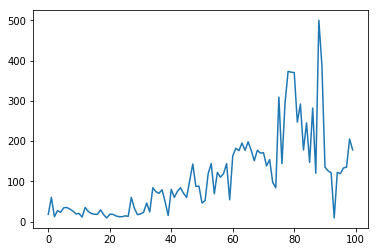

In [74]:
tf.reset_default_graph()

params = LearningParameters(env, env_state_observer.env_reset(env), episodes_count=100)
params.max_frame_in_episode = min(params.max_frame_in_episode, 1000)
params.epsilon_min = 0.05
params.max_memory_size = 20000
params.pong_reset_discounted_reward = False
# agent = PolicyGradientAgent(params)
agent = DqnAgent(params)
# agent = ActionAsInputAgent(params)

run_name += 1
print('Run: ' + str(run_name))

saver = TfSaver('logs/cartpole')

# Train on GPU
# config = tf.ConfigProto(log_device_placement=True)
# config.gpu_options.per_process_gpu_memory_fraction=0.5
# config.operation_timeout_in_ms=60000

# Train on CPU
config = tf.ConfigProto(device_count = {'GPU': 0})

with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())

#     saver.load_latest_checkpoint(session)
    
#     tf_writer = tf.summary.FileWriter('logs/run' + str(run_name), session.graph)

    agent, rewards = train_discounted_rewards(session, saver, env, agent, env_state_observer, params,
                                              normalize_rewards=True)
    # agent, rewards = train_reward_is_time(env, agent, params)
    # agent, rewards = train(env, agent, params)
    plt.plot(rewards)

In [ ]:
# Continue learning
params.episodes_count = 10000
agent, rewards = train_discounted_rewards(env, agent, params, normalize_rewards=True)
plt.plot(rewards)

In [22]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    evaluate(session, env, agent, env_state_observer, params, 500)

Total reward: -4.0


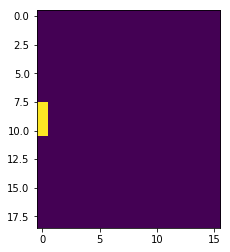

In [23]:
with tf.Session(config=config) as session:
    session.run(tf.global_variables_initializer())
    show(session, env, agent, env_state_observer, params, 200, width=19, height=16, greedy=True)

In [ ]:
# Save rewards/model
pd.DataFrame(rewards).to_csv('models/rewards_40K_50K.csv', header=None)
saver = tf.train.Saver()
saver.save(session, 'models/Pong PolicyGradient', global_step=50000)